# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [21]:
# Importing the file porter_data_1.csv
df = pd.read_csv("/content/porter_data_1.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [22]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [23]:
# Convert categorical features to category type
categorical_columns = ['store_primary_category', 'order_protocol']

for column in categorical_columns:
    df[column] = df[column].astype('category')

# Display the first few rows
display(df.head())


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [24]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [25]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,hour,day_of_week
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1


In [26]:
# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,hour,day_of_week,isWeekend
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3,0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1,0


In [27]:
# Drop unnecessary columns
df = df.drop(['created_at', 'actual_delivery_time'], axis=1)
df.head()


,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,time_taken,hour,day_of_week,isWeekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,0
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3,0
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1,0


In [20]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken', 'hour',
       'day_of_week', 'isWeekend'],
      dtype='object')

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [28]:
# Define target variable (y) and features (X)
y = df['time_taken']
X = df.drop('time_taken', axis=1)




##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [29]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [30]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['category']).columns

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

<Figure size 1200x800 with 0 Axes>

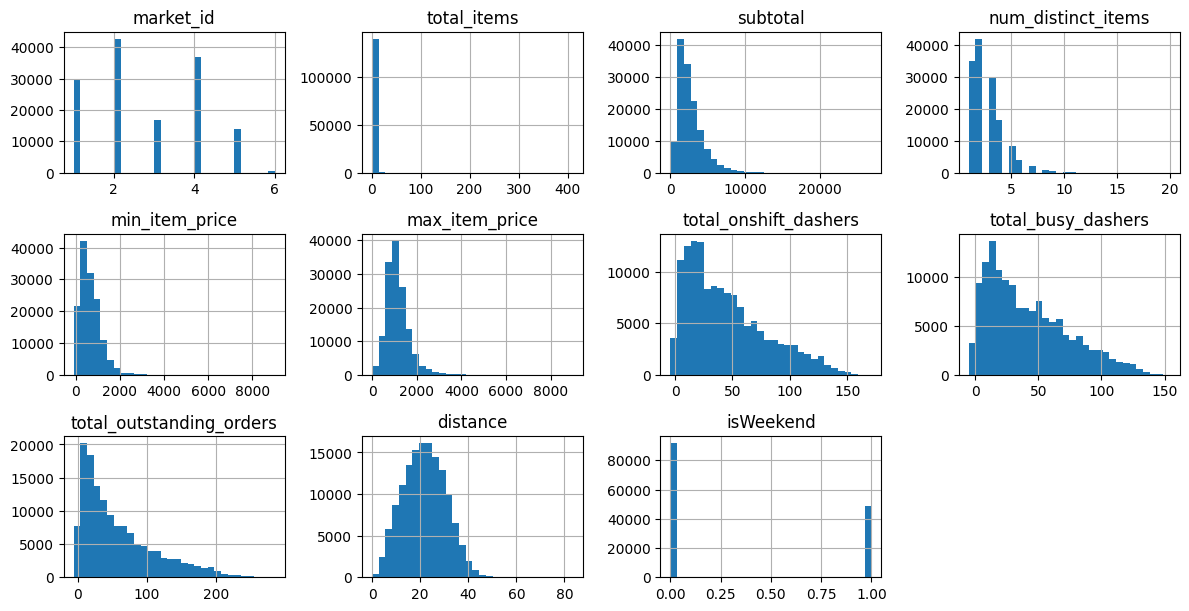

In [31]:
# Plot distributions for all numerical columns
plt.figure(figsize=(12, 8))
X_train[numerical_cols].hist(bins=30, figsize=(12, 8), layout=(4, 4))
plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

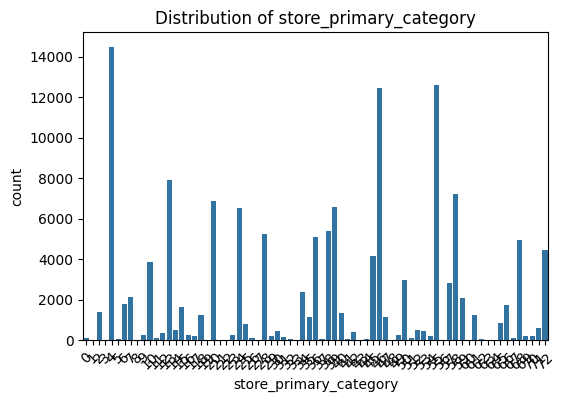

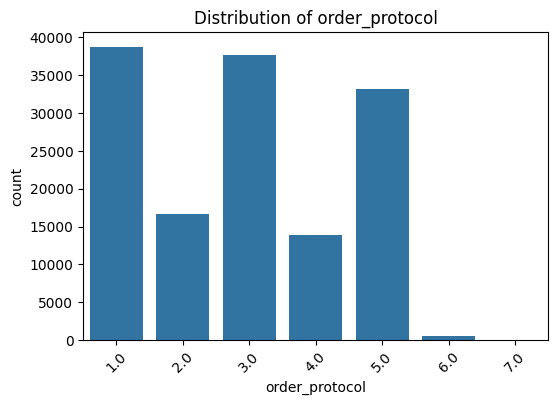

In [ ]:
# Distribution of categorical columns

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=X_train[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

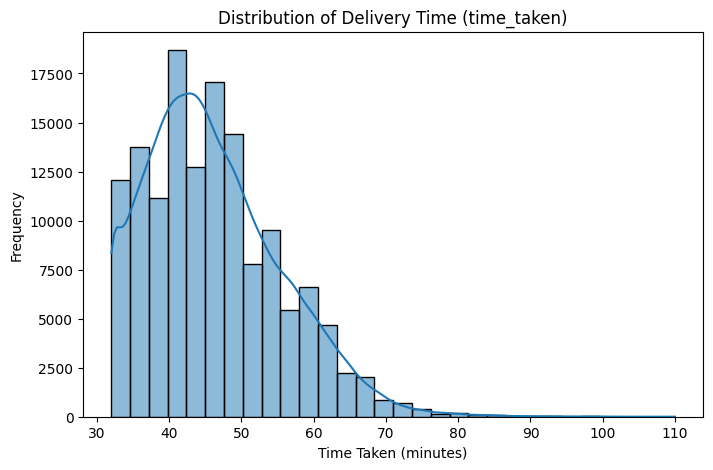

In [ ]:
# Distribution of time_taken

plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Distribution of Delivery Time (time_taken)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

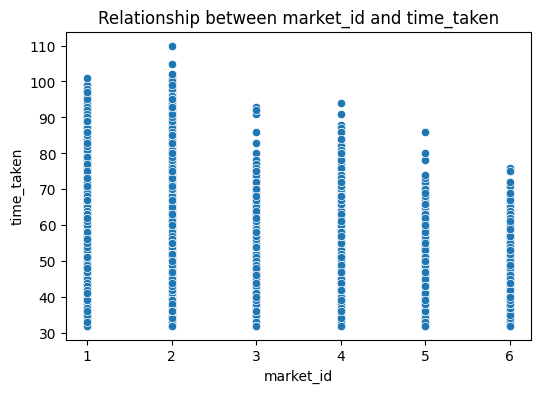

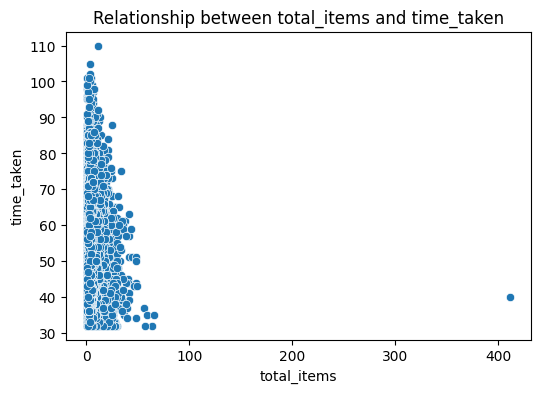

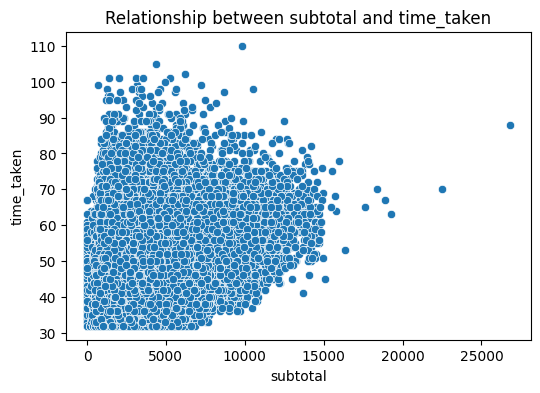

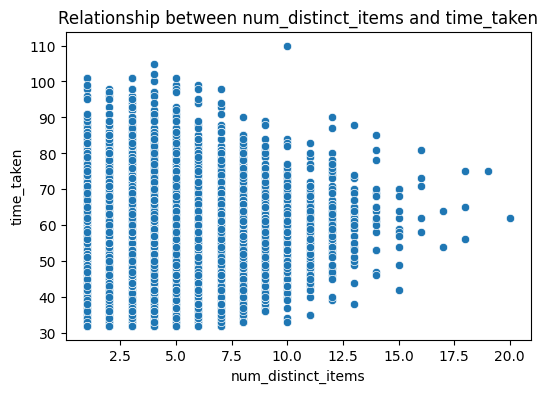

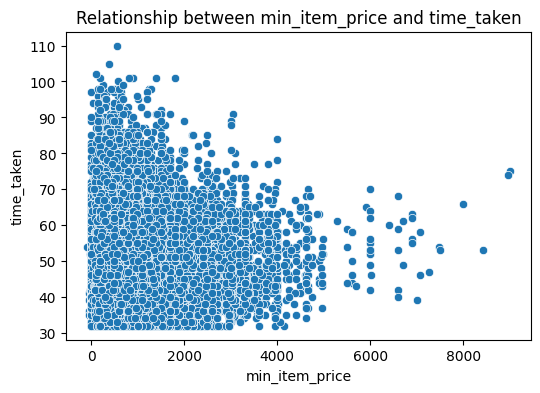

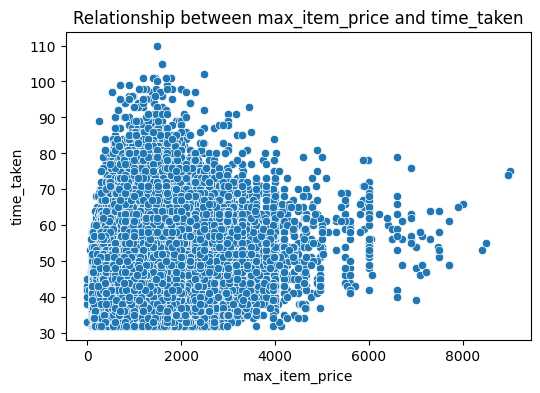

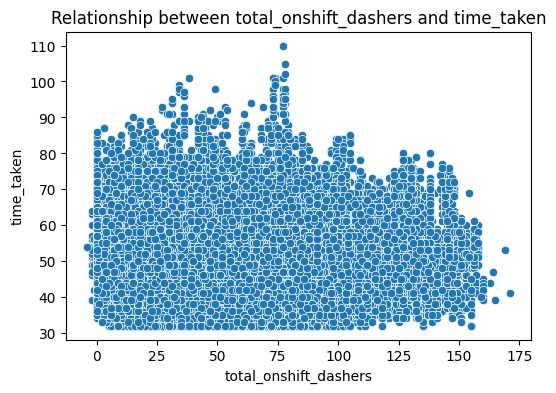

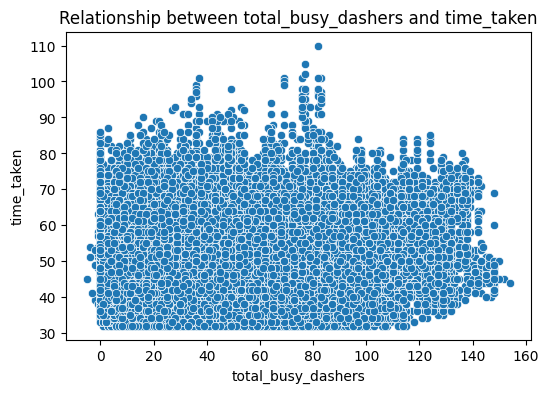

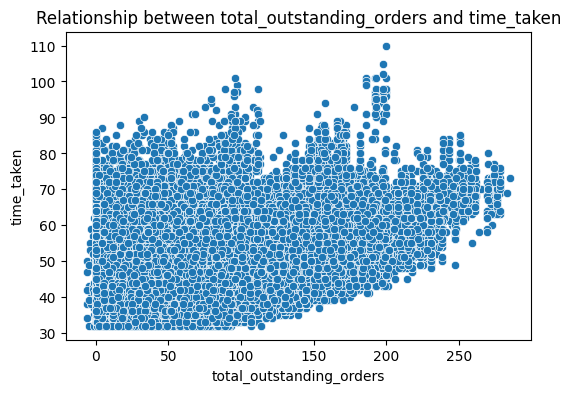

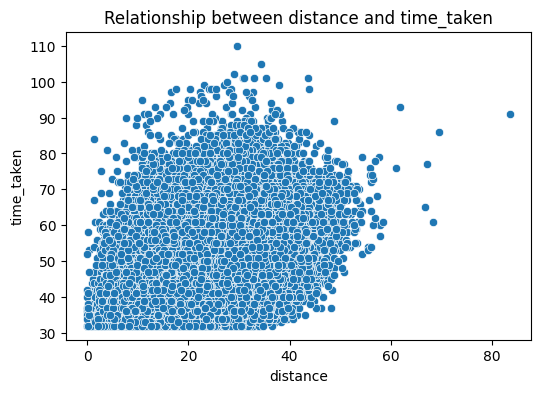

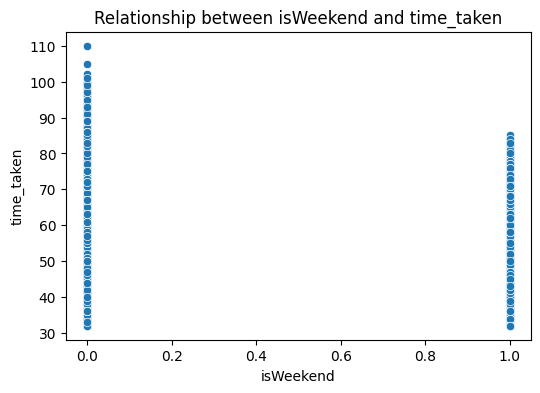

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Relationship between {col} and time_taken')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.show()



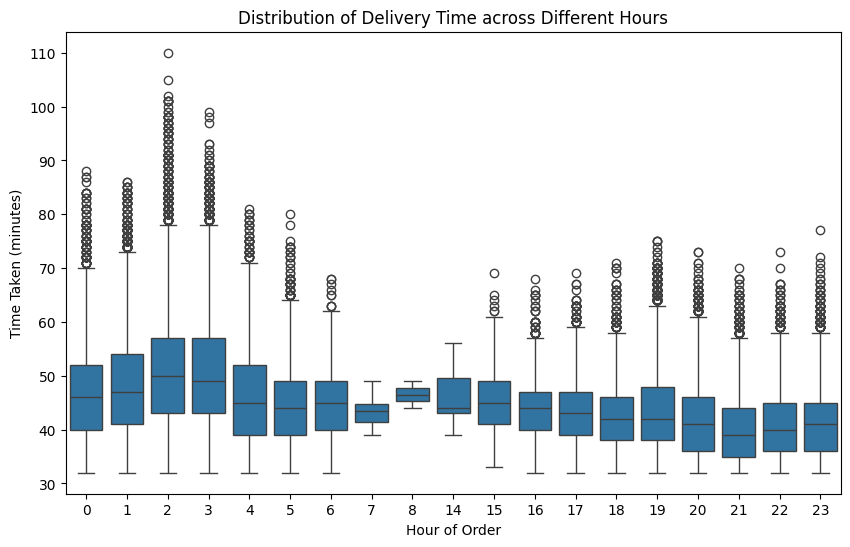

In [ ]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(10, 6))
sns.boxplot(x=X_train['hour'], y=y_train)
plt.title('Distribution of Delivery Time across Different Hours')
plt.xlabel('Hour of Order')
plt.ylabel('Time Taken (minutes)')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

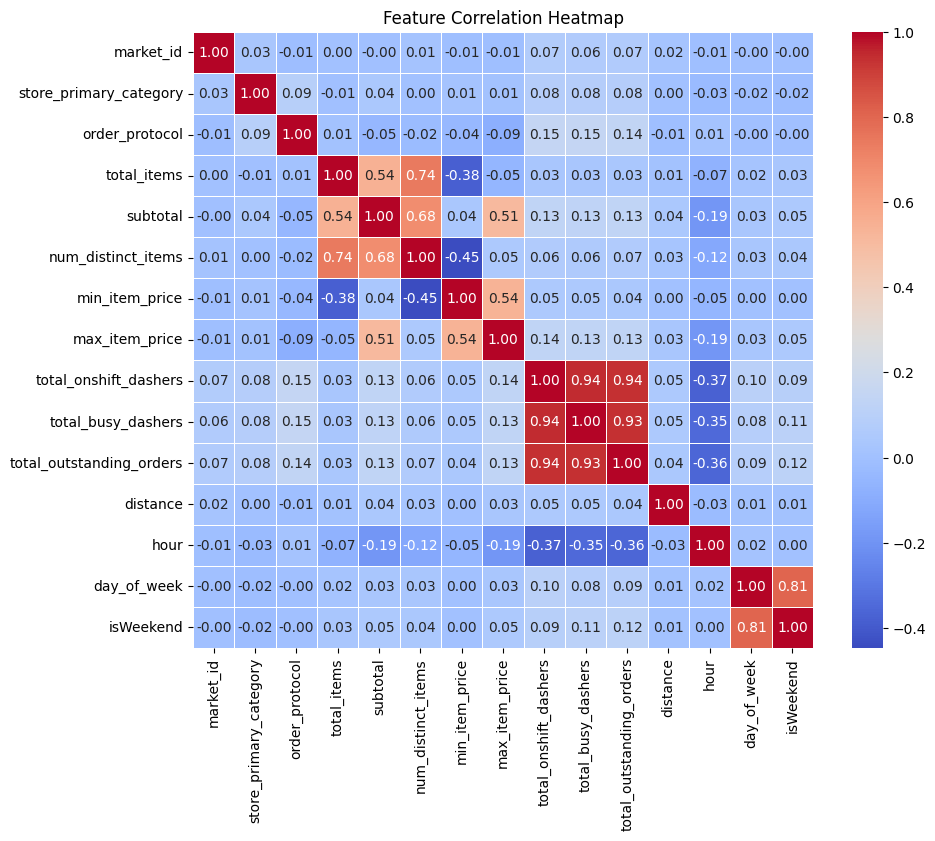

In [32]:
# Plot the heatmap of the correlation matrix

plt.figure(figsize=(10, 8))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [33]:
# Drop 3-5 weakly correlated columns from training dataset
weak_corr_cols = corr_matrix.abs().mean().sort_values().head(5).index.tolist()

X_train.drop(columns=weak_corr_cols, inplace=True)
X_test.drop(columns=weak_corr_cols, inplace=True)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

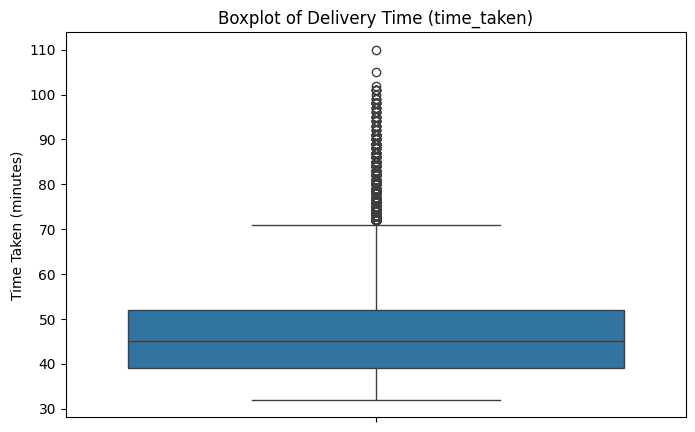

In [34]:
# Boxplot for time_taken
plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train)
plt.title('Boxplot of Delivery Time (time_taken)')
plt.ylabel('Time Taken (minutes)')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [35]:
# Handle outliers
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (y_train >= lower_bound) & (y_train <= upper_bound)
X_train, y_train = X_train[outlier_mask], y_train[outlier_mask]


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [36]:
# Define numerical and categorical columns for easy EDA and data manipulation

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

<Figure size 1200x800 with 0 Axes>

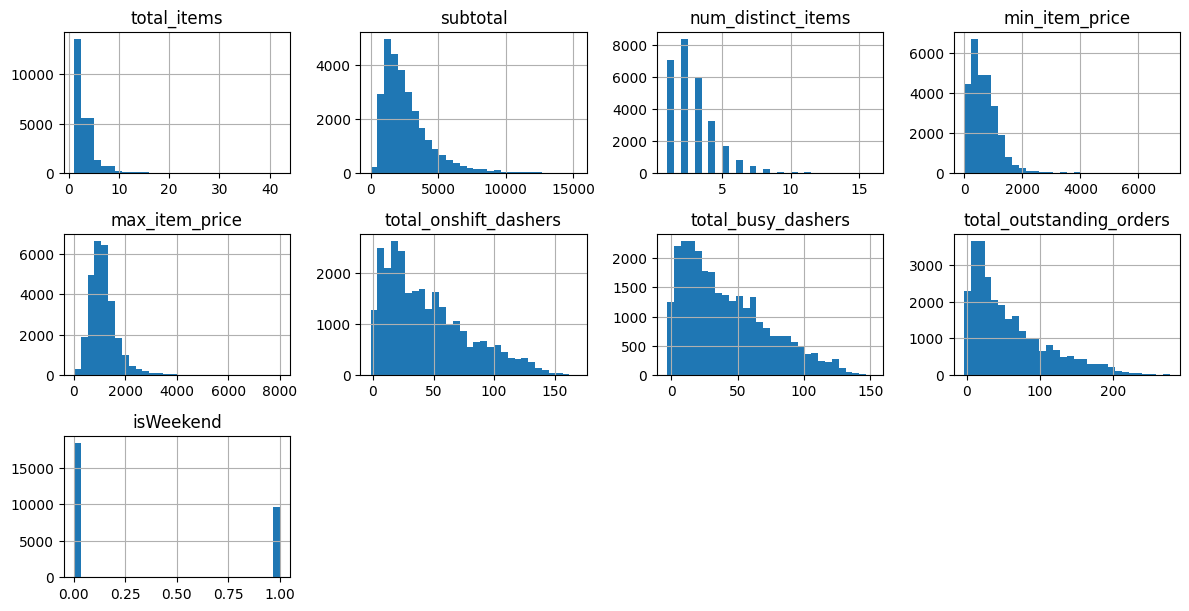

In [37]:
# Plot distributions for all numerical columns
numerical_cols = X_val.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
X_val[numerical_cols].hist(bins=30, figsize=(12, 8), layout=(4, 4))
plt.tight_layout()
plt.show()


##### **4.1.2**
Check the distribution of categorical features

In [38]:
categorical_cols = X_val.select_dtypes(include=['category']).columns

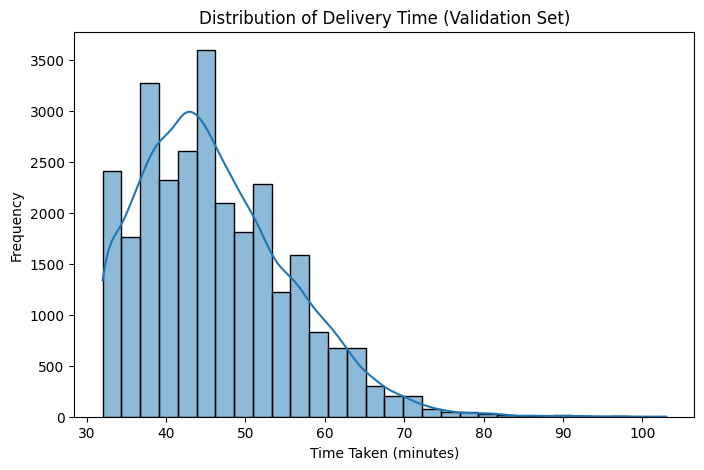

In [39]:
# Distribution of categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=X_val[col])
    plt.title(f'Distribution of {col} (Validation Set)')
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(y_val, bins=30, kde=True)
plt.title('Distribution of Delivery Time (Validation Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

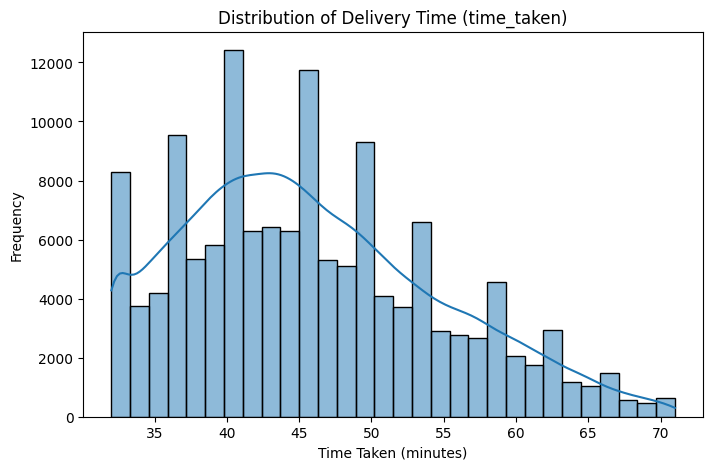

In [40]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Distribution of Delivery Time (time_taken)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

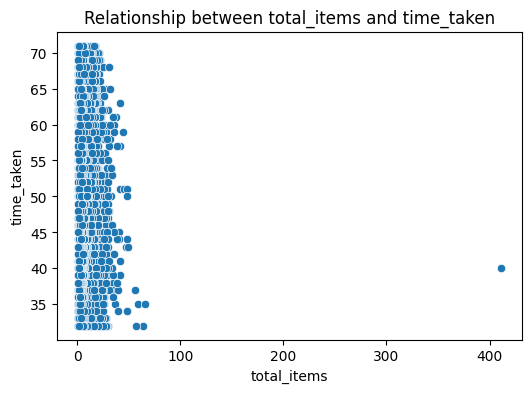

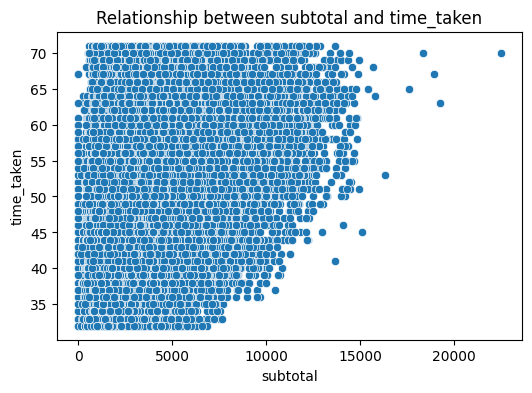

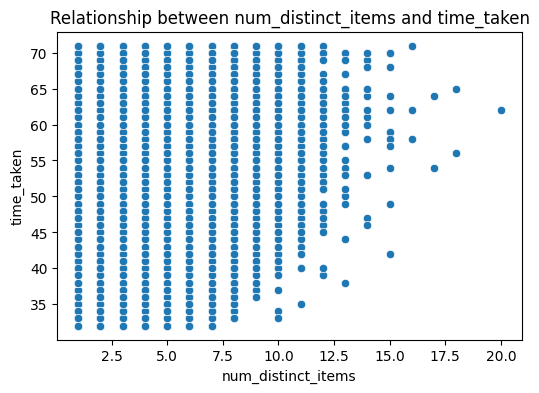

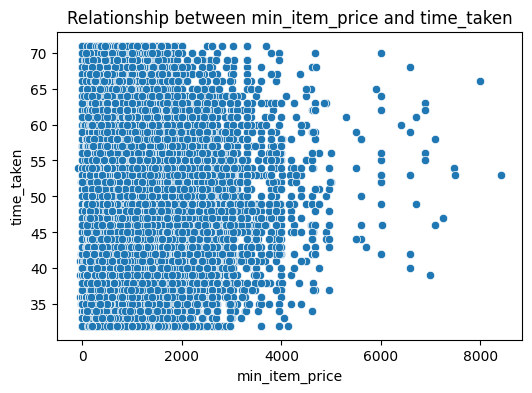

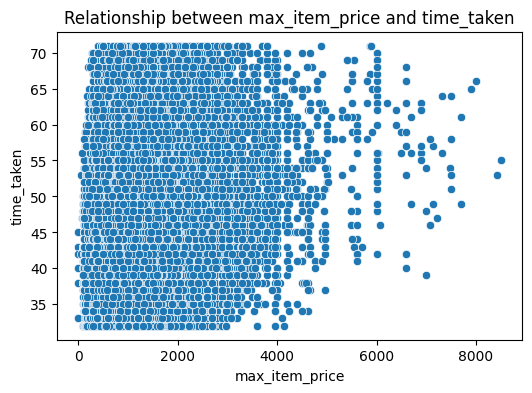

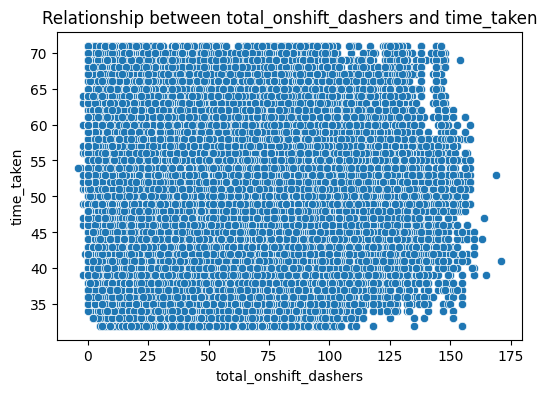

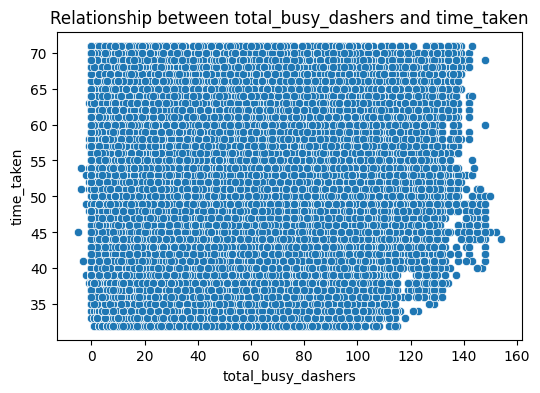

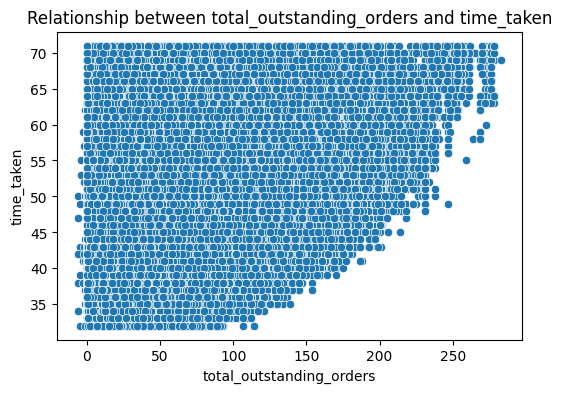

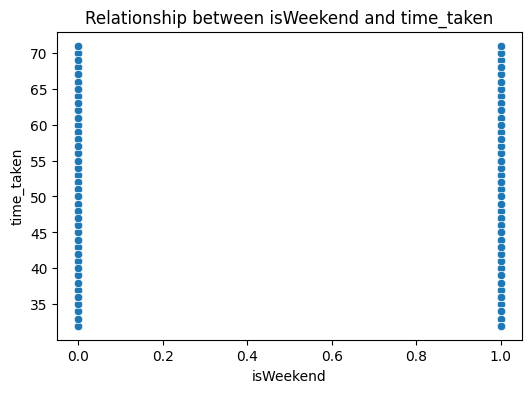

In [41]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Relationship between {col} and time_taken')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.show()


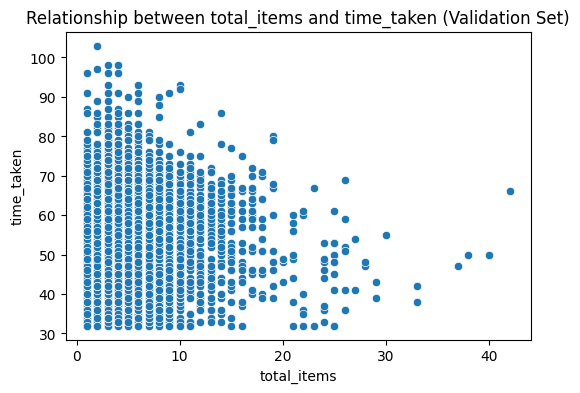

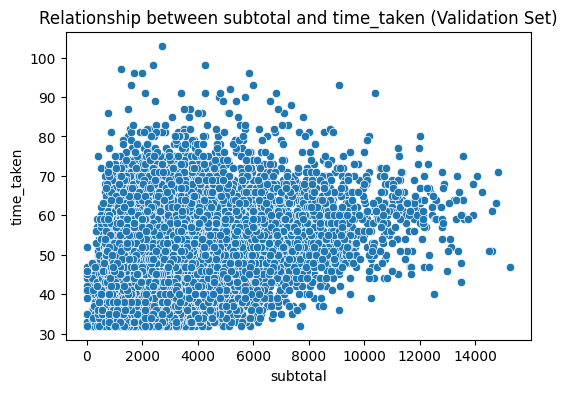

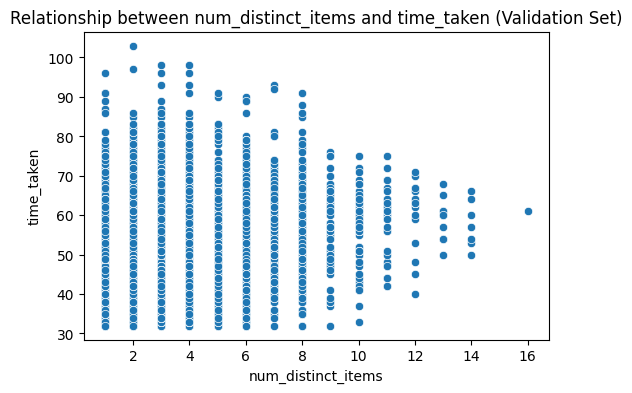

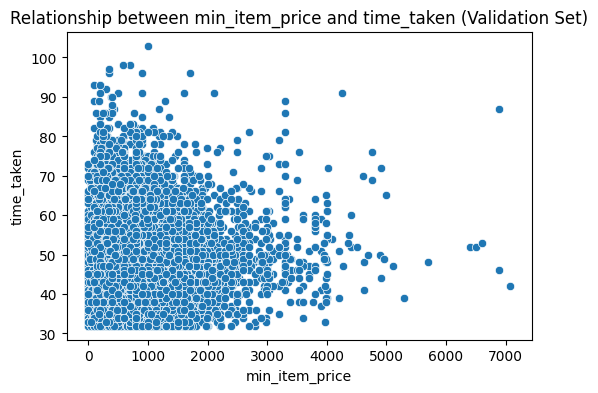

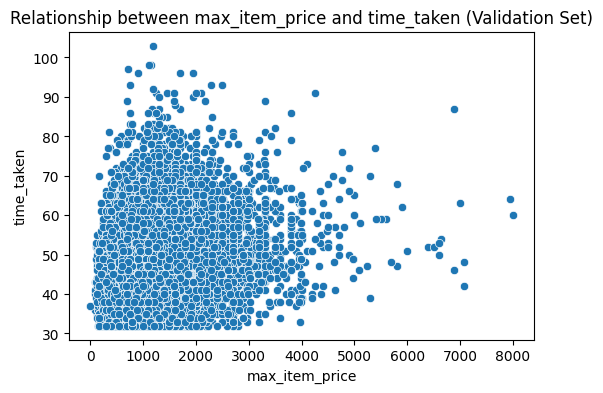

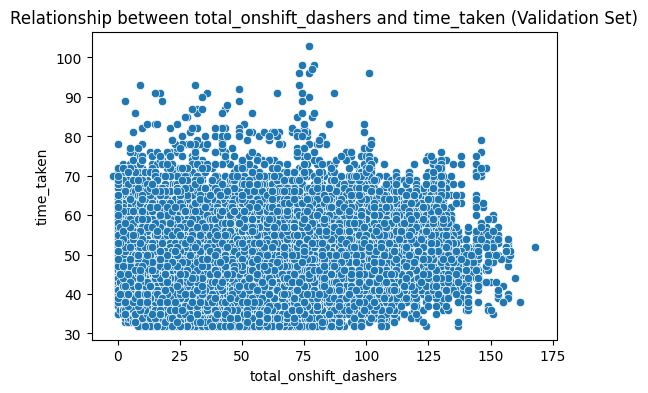

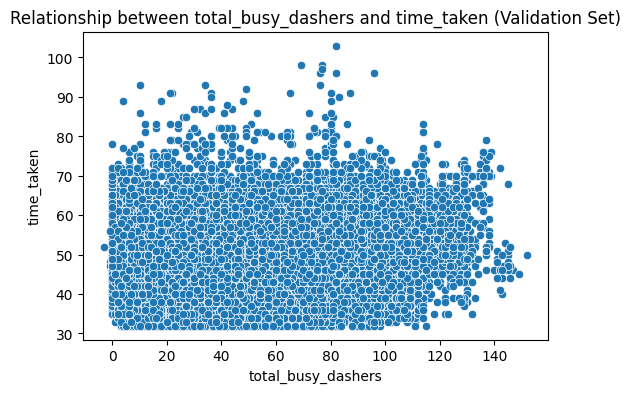

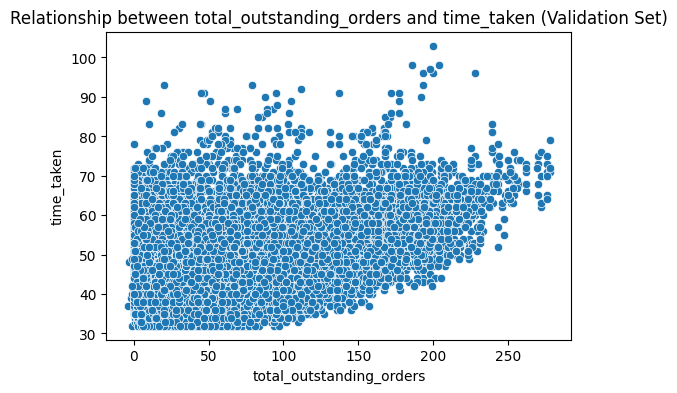

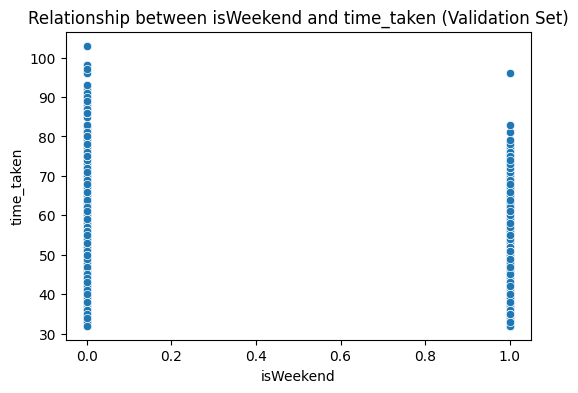

In [42]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_val[col], y=y_val)
    plt.title(f'Relationship between {col} and time_taken (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [43]:
# Drop the weakly correlated columns from training dataset
corr_matrix_val = X_val.corr()
weak_corr_cols_val = corr_matrix_val.abs().mean().sort_values().head(5).index.tolist()
X_val.drop(columns=weak_corr_cols_val, inplace=True)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [44]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Apply scaling to the numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [57]:
# Create/Initialise the model
model = LinearRegression()


In [58]:
# Train the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [59]:
# Make predictions
y_pred = model.predict(X_test)

In [60]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [61]:
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Absolute Error: 2.33943717950946
Mean Squared Error: 10.392724449740538
R-squared Score: 0.8812630306152398


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [53]:
from sklearn.feature_selection import RFE

In [54]:
# Loop through the number of features and test the model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
selected_features = X_train.columns[rfe.support_]
print(f"Selected Features: {selected_features.tolist()}")


Selected Features: ['market_id', 'order_protocol', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']


In [55]:
# Build the final model with selected number of features
final_model = LinearRegression()
final_model.fit(X_train_rfe, y_train)


LinearRegression()

In [56]:
# Make predictions
y_pred = final_model.predict(X_test_rfe)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

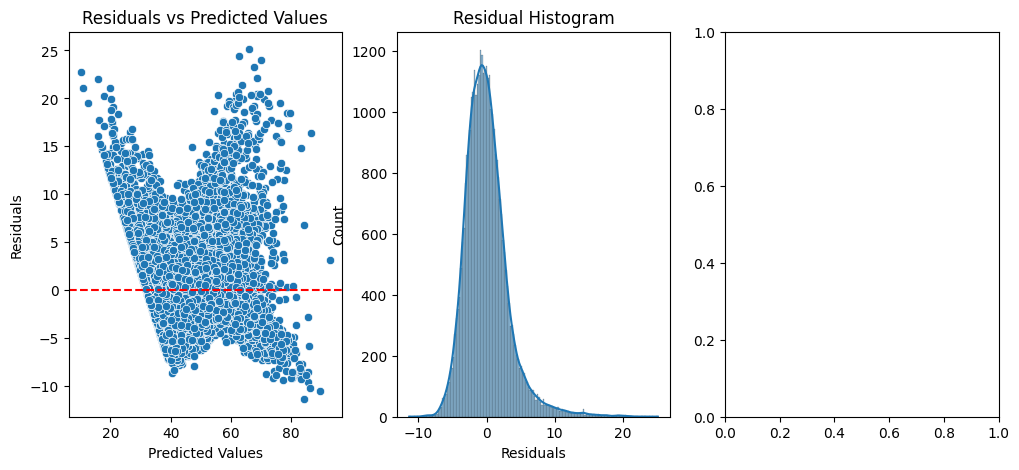

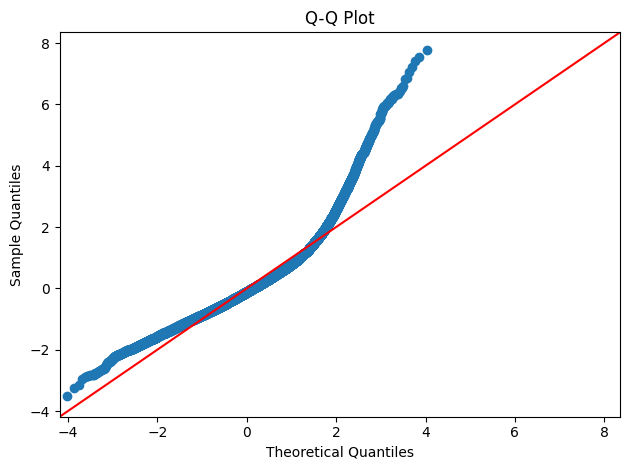

In [62]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

residuals = y_test - y_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")



plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Histogram")


plt.subplot(1, 3, 3)
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot")

plt.tight_layout()
plt.show()


[Your inferences here:]

---

1. Residuals vs. Predicted Values:

The residuals are not randomly distributed around zero; rather, they show a distinct pattern, which indicates heteroscedasticity. This suggests that the model is not capturing some patterns in the data, potentially due to missing nonlinear relationships or unaccounted interactions.

The fan-shaped pattern suggests that variance increases as predicted values increase. This could indicate that our model does not generalize well for higher values of time_taken.


2. Residual Histogram:

The histogram is slightly skewed to the right, indicating that the residuals are not perfectly normally distributed. This suggests that the model might have issues in predicting extreme delivery times.

3. Q-Q Plot:

The Q-Q plot shows that residuals deviate from the normal distribution, especially at the tails. The upward bend at higher quantiles indicates that extreme values are more common than expected in a normal distribution.



Coefficient Analysis
The feature coefficients indicate how much each variable affects time_taken, assuming all other variables remain constant.






In [65]:
from IPython.display import display, HTML

table_data = [
    ["Feature", "Coefficient", "Interpretation"],
    ["total_outstanding_orders", "18.49", "A significant positive effect, meaning higher outstanding orders increase delivery time."],
    ["subtotal", "2.47", "More expensive orders take slightly longer to deliver."],
    ["num_distinct_items", "0.98", "A minor increase in delivery time as more unique items are ordered."],
    ["max_item_price", "0.70", "Higher-priced items may take longer to prepare."],
    ["market_id", "-0.61", "Market location has a slight negative impact, suggesting some markets may have faster deliveries."],
    ["order_protocol", "-0.79", "Different ordering methods might reduce delivery time."],
    ["total_busy_dashers", "-4.51", "More busy dashers correlate with slightly faster deliveries."],
    ["total_onshift_dashers", "-11.70", "More dashers available lead to significantly faster delivery times."]
]

html_table = "<table><tr>" + "</tr><tr>".join(["<th>" + "</th><th>".join(row) + "</th>" for row in table_data]) + "</tr></table>"

display(HTML(html_table))

Feature,Coefficient,Interpretation
total_outstanding_orders,18.49,"A significant positive effect, meaning higher outstanding orders increase delivery time."
subtotal,2.47,More expensive orders take slightly longer to deliver.
num_distinct_items,0.98,A minor increase in delivery time as more unique items are ordered.
max_item_price,0.70,Higher-priced items may take longer to prepare.
market_id,-0.61,"Market location has a slight negative impact, suggesting some markets may have faster deliveries."
order_protocol,-0.79,Different ordering methods might reduce delivery time.
total_busy_dashers,-4.51,More busy dashers correlate with slightly faster deliveries.
total_onshift_dashers,-11.70,More dashers available lead to significantly faster delivery times.


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [63]:
# Compare the scaled vs unscaled features used in the final model
coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': final_model.coef_})
print("Feature Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))


Feature Coefficients:
                    Feature  Coefficient
7  total_outstanding_orders    18.489418
2                  subtotal     2.465844
3        num_distinct_items     0.978516
4            max_item_price     0.697740
0                 market_id    -0.605434
1            order_protocol    -0.793372
6        total_busy_dashers    -4.506543
5     total_onshift_dashers   -11.703965


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [64]:
# Analyze the effect of a unit change in a feature, say 'total_items'
if 'total_items' in selected_features:
    total_items_coef = final_model.coef_[selected_features.index('total_items')]
    print(f"A unit increase in 'total_items' changes delivery time by {total_items_coef:.4f} minutes (scaled effect).")



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?


**Answer:**


>Analysis of Categorical Variables and Their Effect on Delivery Time
From your dataset, the categorical variables are:


store_primary_category (Type of store, e.g., restaurant, grocery, etc.)


order_protocol (Indicates the ordering method used)

isWeekend (Whether the order was placed on a weekend)


Inference from Categorical Variables:

store_primary_category

Different store categories may have varying preparation times.

For example, fast food chains might have quicker delivery times than grocery deliveries.

order_protocol

The ordering protocol might indicate different processing mechanisms.

Some order protocols (e.g., API-based, phone-in orders) may result in faster processing.

The feature was selected in the final model, indicating its impact on delivery time.


isWeekend

Orders placed on weekends could be delayed due to higher demand or traffic conditions.

If the coefficient for this feature is positive, weekends may have longer delivery times.


Conclusion


order_protocol was retained → This suggests it has a significant effect on delivery time.

Dropping store_primary_category seems valid if it had a low correlation with delivery time.

Analyzing isWeekend could be beneficial in future models to check for weekend delays.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>Yes, the dataset contains categorical variables such as store_primary_category, order_protocol, and isWeekend.



store_primary_category

Represents the type of store (e.g., restaurant, grocery, etc.).

Different store types might have different preparation and processing times, affecting delivery time.

However, this feature was dropped during preprocessing, indicating it had less impact on the target variable.



order_protocol

Represents the method of ordering (e.g., API, phone, etc.).

This feature was selected in the final model, suggesting it influences delivery time.

Some protocols might process orders faster than others.


isWeekend

A binary feature indicating whether the order was placed on a weekend (1) or not (0).

Orders on weekends may have longer delivery times due to increased demand and traffic.

Further analysis (e.g., statistical tests) could confirm its impact.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>
From the heatmap, total_outstanding_orders shows the strongest positive correlation with the target variable



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**


We used boxplots and the IQR (Interquartile Range) method to detect and remove outliers:

1. Outlier Detection

Plotted boxplots for numerical columns (like time_taken, total_items, etc.) to visually inspect extreme values.

Calculated the IQR = Q3 – Q1 for each feature.

Defined upper and lower bounds as Q1 – 1.5 × IQR and Q3 + 1.5 × IQR, respectively.

2. Outlier Removal

Any data points outside these bounds were considered outliers.

Filtered the dataset to keep only observations within those bounds (i.e., lower_bound <= value <= upper_bound).

This approach helps improve model performance by removing extreme values that might otherwise skew the training process.



>



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>From the final model’s coefficients, the top three features (by absolute magnitude) that most significantly affect delivery time are:

total_outstanding_orders (Coefficient: +18.49)

total_onshift_dashers (Coefficient: -11.70)

total_busy_dashers (Coefficient: -4.51)

total_outstanding_orders has the largest positive impact, indicating that more outstanding orders at the time of ordering leads to longer delivery times.

total_onshift_dashers has a large negative coefficient, implying that having more dashers available can significantly reduce delivery times.

total_busy_dashers is also negative, suggesting that, somewhat counterintuitively, higher numbers of busy dashers at the time may correlate with shorter delivery times—potentially because busy dashers are already actively delivering, so new orders get assigned to free dashers more efficiently



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression Algorithm
Introduction
Linear Regression is a supervised learning algorithm used for predicting continuous numerical values. It establishes a relationship between the dependent variable (target) and one or more independent variables (features) by fitting a linear equation to the data.

Mathematical Representation
For a single variable (Simple Linear Regression):
$ y = mx + c $$ y = mx + c $ Where:

$y$$y$ = Predicted value (dependent variable)
$x$$x$ = Feature (independent variable)
$m$$m$ = Slope of the line (coefficient)
$c$$c$ = Intercept (bias)
For multiple variables (Multiple Linear Regression):
$ y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b $$ y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b $ Where:

$x_1, x_2, ..., x_n$$x_1, x_2, ..., x_n$ are feature variables
$w_1, w_2, ..., w_n$$w_1, w_2, ..., w_n$ are weights (coefficients)
$b$$b$ is the bias term
Cost Function (Mean Squared Error - MSE)
The cost function measures the error between the predicted and actual values. The most commonly used cost function for Linear Regression is Mean Squared Error (MSE):

$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

Where:

$y_i$$y_i$ = Actual value
$\hat{y}_i$$\hat{y}_i$ = Predicted value
$n$$n$ = Number of observations
Optimization using Gradient Descent
To minimize the cost function, we update the weights using Gradient Descent. The update rule for each weight $w_j$$w_j$ is:

$ w_j = w_j - \alpha \frac{\partial}{\partial w_j} J(w) $$ w_j = w_j - \alpha \frac{\partial}{\partial w_j} J(w) $

Where:

$\alpha$$\alpha$ = Learning rate
$J(w)$$J(w)$ = Cost function
Assumptions of Linear Regression
Linearity – The relationship between independent and dependent variables is linear.
Independence – Observations are independent of each other.
Homoscedasticity – Constant variance of residuals.
No multicollinearity – Independent variables should not be highly correlated.
Normality of residuals – Residuals should be normally distributed.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Linear regression is a fundamental technique used to model the relationship between a dependent variable and one or more independent variables. The key difference between Simple Linear Regression and Multiple Linear Regression lies in the number of independent variables used.



## Key Differences

| Feature | Simple Linear Regression | Multiple Linear Regression |
|---|---|---|
| Number of Features | One independent variable | Two or more independent variables |
| Equation | $y = mx + c$ | $y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b$ |
| Use Case | Predicting using a single factor | Predicting using multiple factors |
| Complexity | Low | Higher |
| Interpretability | Easy to visualize (2D) | Harder to visualize (Multidimensional) |
| Example | Predicting salary based on years of experience | Predicting salary based on experience, education, and job role |



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>Role of the Cost Function in Linear Regression and Its Minimization
In linear regression, the goal is to find the best-fitting line that minimizes the difference between predicted and actual values. This is achieved using a cost function that measures how well the model is performing.

1. Role of the Cost Function
The cost function in linear regression quantifies the error between the predicted values ($\hat{y}$$\hat{y}$) and the actual values ($y$$y$). The most commonly used cost function is the Mean Squared Error (MSE), defined as:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$

where:

$J(\theta)$$J(\theta)$ = Cost function (error)
$m$$m$ = Number of training examples
$y_i$$y_i$ = Actual value of the target variable
$\hat{y}_i$$\hat{y}_i$ = Predicted value
$\theta$$\theta$ = Model parameters (weights and bias)
The cost function ensures that:

A smaller cost means better model performance.
A larger cost means a poor fit.
2. Minimizing the Cost Function
To find the optimal values of $\theta$$\theta$ (weights and bias) that minimize the cost function, we use optimization algorithms such as:

A. Gradient Descent (Most Common Method)
Gradient descent iteratively updates the parameters to minimize the cost function using the formula:

$\theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$$\theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$

where:

$\alpha$$\alpha$ = Learning rate (step size for updates)
$\frac{\partial J(\theta)}{\partial \theta_j}$$\frac{\partial J(\theta)}{\partial \theta_j}$ = Partial derivative of the cost function with respect to $\theta_j$$\theta_j$
Steps in Gradient Descent:

Initialize $\theta$$\theta$ (weights and bias) randomly.
Compute the cost function.
Calculate the gradient (slope) of the cost function.
Update $\theta$$\theta$ by moving in the direction of steepest descent.
Repeat until convergence (when cost no longer decreases significantly).




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Difference Between Overfitting and Underfitting
In machine learning, overfitting and underfitting are two common issues that occur when training a model. These problems affect the model's ability to generalize well to unseen data.

1. Overfitting
Definition
Overfitting occurs when a model learns the training data too well, capturing noise and random fluctuations instead of the underlying pattern. The model becomes too complex, fitting the training data perfectly but performing poorly on new data.

Symptoms of Overfitting
High training accuracy, but low test accuracy

Large gap between training and validation errors

Model performs well on known data but poorly on unseen data

Causes of Overfitting
Too many features or too complex a model

Training the model for too many iterations

Insufficient training data

How to Reduce Overfitting?
Feature Selection: Remove irrelevant features

Regularization: Use L1 (Lasso) or L2 (Ridge) regularization

More Data: Increase training data using data augmentation

Early Stopping: Stop training when validation loss starts increasing

2. Underfitting
Definition
Underfitting happens when a model is too simple and fails to learn the underlying pattern in the data. It results in both high training and test error.

Symptoms of Underfitting
High bias and low variance

Poor performance on both training and test data

Model is too simple and does not capture relationships in data

Causes of Underfitting
Model is too simple (e.g., using linear regression for highly non-linear data)

Insufficient training time

Poor feature selection

How to Reduce Underfitting?
Increase Model Complexity: Use more complex models (e.g., neural networks, decision trees)

More Features: Add relevant features that capture patterns in the data

Train for Longer: Ensure the model is trained for enough epochs



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual Plots in Linear Regression
A residual plot is a key diagnostic tool in regression analysis that helps assess the validity of the model. It plots the residuals (errors) on the y-axis against the predicted values on the x-axis.


1. Understanding Residuals
Residual (Error) = Actual Value - Predicted Value


A good regression model should have residuals that are randomly scattered without patterns.


2. How Residual Plots Help?

(a) Checking for Linearity

Good Model: If the residuals are randomly scattered, the assumption of linearity holds.

Problem: If the residuals show a curved pattern, the relationship is non-linear, meaning a linear model may not be appropriate.


(b) Identifying Heteroscedasticity (Unequal Variance)

Good Model: Residuals have constant variance (homoscedasticity).


Problem: If the residuals fan out (increasing spread), the model suffers from heteroscedasticity, indicating that variance is not constant.


(c) Detecting Outliers

Good Model: Residuals are mostly within a narrow range.

Problem: Extreme residual values indicate outliers, which can bias the model.

(d) Checking for Independence of Errors

Good Model: Residuals do not show systematic patterns.

Problem: If residuals are autocorrelated (forming a wave-like pattern), then the errors are dependent, violating the assumption of independent observations.

3. Types of Residual Plots

(a) Residuals vs. Predicted Values Plot

Checks for linearity & heteroscedasticity.
Residuals should be evenly spread around the horizontal line at zero.

(b) Residual Histogram

Checks if residuals are normally distributed.
A skewed distribution may indicate missing important features.

(c) Q-Q Plot (Quantile-Quantile Plot)

Compares residuals to a normal distribution.
Points should lie close to the diagonal line.